# Dailey Sales Predictor

## Feature engineering

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read data
df = pd.read_excel('sales_data.xlsx')
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


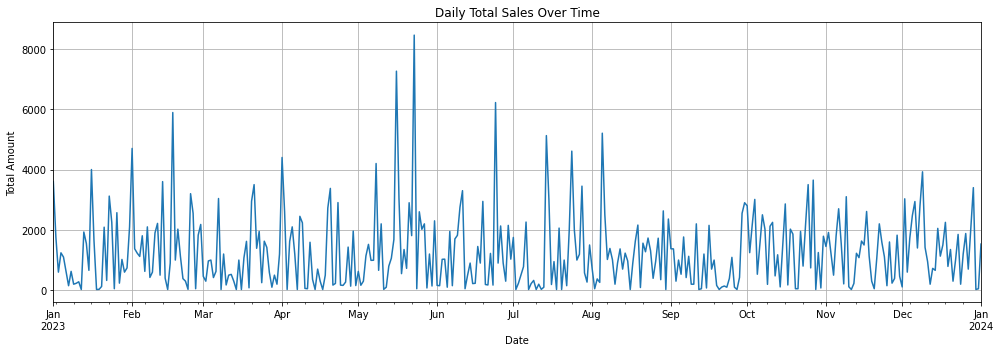

In [3]:
# Accumulate daily total sales
df['Date'] = pd.to_datetime(df['Date'])

# Set up full date range to including missing days
full_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')

# Accumulate the daily sales
daily_sales = df.groupby('Date')['Total Amount'].sum()

# Fill the missing days with min sale value
min_sale = daily_sales.min()
daily_sales = df.groupby('Date')['Total Amount'].sum().reindex(full_range).fillna(min_sale)

# Plot the accumulated daily sales data
daily_sales.plot(figsize=(14, 5), title="Daily Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** <br>
From the above plot, we observe that there is extreme variability and some outliers. These outlying spikes are rarely observed for e.g, in Feb, May, June and July. These may happen due to holidays, discounted days, marketing, campaigns and other things. Since, those information is unavailable in the current dataset, clipping becomes critical here to ensure that the model is not distracted by extreme and unexplainable sales spikes.

### Detect outliers and Clip

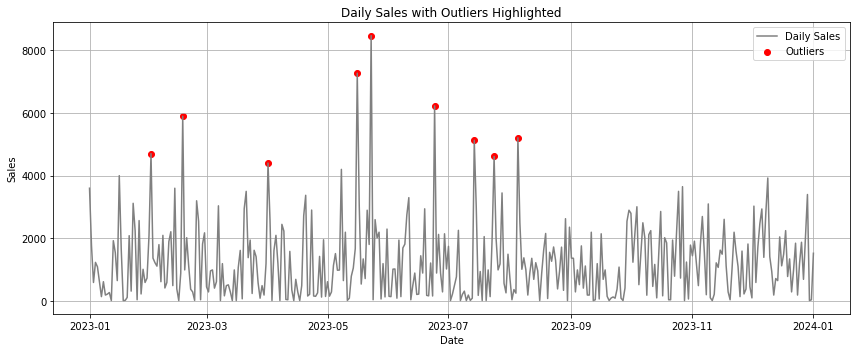

In [4]:
# Detect outliers based on IQR Method
q1 = daily_sales.quantile(0.25)
q3 = daily_sales.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Find outliers
outliers = (daily_sales < lower_bound) | (daily_sales > upper_bound)

# Plot the detected outliers
plt.figure(figsize=(12, 5))
plt.plot(daily_sales.index, daily_sales.values, label="Daily Sales", color='gray')
plt.scatter(daily_sales.index[outliers], daily_sales[outliers], color='red', label='Outliers')
plt.title("Daily Sales with Outliers Highlighted")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

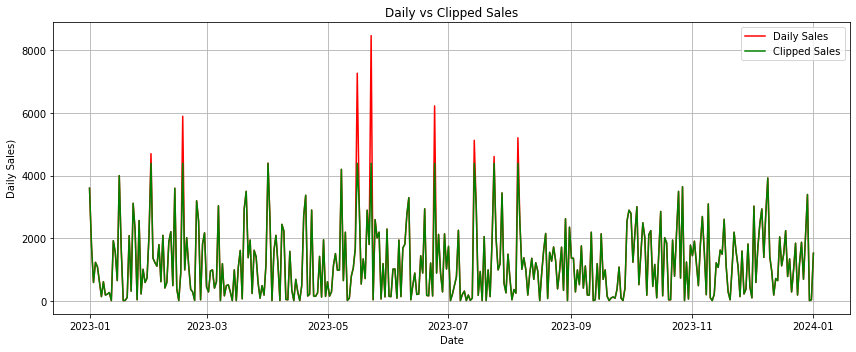

In [5]:
# Clip outliers with windowing method
clipped_sales = daily_sales.clip(lower=lower_bound, upper=upper_bound)

# Plot dailey sales and clipped sales together
plt.figure(figsize=(12, 5))
plt.plot(daily_sales.index, daily_sales, label="Daily Sales", color='red')
plt.plot(clipped_sales.index, clipped_sales, label="Clipped Sales", color='green')
plt.title("Daily vs Clipped Sales")
plt.ylabel("Daily Sales)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Create final DataFrame with Date as column
aggregated_df = pd.DataFrame({
    'Date': daily_sales.index,
    'DailySales': daily_sales.values,
    'ClippedSales': clipped_sales.values
})

# Preview the aggregated DF
print(aggregated_df.head())

        Date  DailySales  ClippedSales
0 2023-01-01      3600.0        3600.0
1 2023-01-02      1765.0        1765.0
2 2023-01-03       600.0         600.0
3 2023-01-04      1240.0        1240.0
4 2023-01-05      1100.0        1100.0


**Observation:** <br>
Even with clipping, there is still large variation in the dataset. To tackle this, we will log transform the dailey sales values. Log transfrom will compress the high values and strech the low values, which will help the models learn easier and will eventually stablize the variance.

### Log - Transform

In [7]:
# Log transform the clidded sales add in the dataframe
clipped_sales_log = np.log1p(aggregated_df['ClippedSales'])
aggregated_df['ClippedSalesLog'] = clipped_sales_log

# Preview the aggregated DF
print(aggregated_df.head())

        Date  DailySales  ClippedSales  ClippedSalesLog
0 2023-01-01      3600.0        3600.0         8.188967
1 2023-01-02      1765.0        1765.0         7.476472
2 2023-01-03       600.0         600.0         6.398595
3 2023-01-04      1240.0        1240.0         7.123673
4 2023-01-05      1100.0        1100.0         7.003974


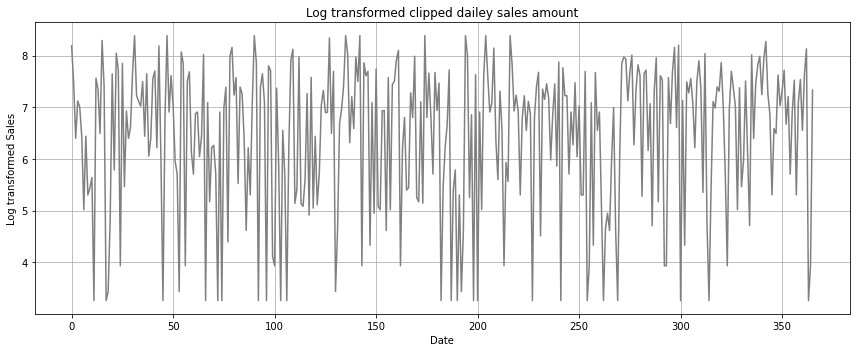

In [8]:
# Plot the log transformed clipped dailey sales
plt.figure(figsize=(12, 5))
plt.plot(clipped_sales_log.index, clipped_sales_log.values, color='gray')
plt.title("Log transformed clipped dailey sales amount")
plt.ylabel("Log transformed Sales")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** <br>
The variation looks much stable now. All the values now lies with 3 to 9 range. Now, this plot confirms that the data is stationary, less-skewed and reasonably bounded. Now, the data is ready for modelling.

### Export data as CSV

In [9]:
# Export the daily sales data
aggregated_df.to_csv("daily_sales_preprocessed.csv", index=True)

## Forecast Modelling

The sales can be predicted with both univariate and multivariate models. <br>

**Univariate model:** <br>
Any model whihc uses only the previous values of a single variable to predict its future. It is used when only internal patterns within target variable is important. It is a simpler model, which is easier to understand. <br>
Example: Auto-Regressive(AR) Models, Moving Average(MA) models, etc.
<br>

**Multi-variate model:** <br>
Any model which uses target variable and other features too to predict its future. It is used when internal patterns within target variable and external influences are important as well. It is a complex model, which may demand excessive feature engineering. <br>
Example: Gradient Boosting Models, Random forest models, etc.

### Model - 1 : AR(p) model -> Baseline

In [10]:
# Import libraries
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tools.eval_measures import rmse, aic

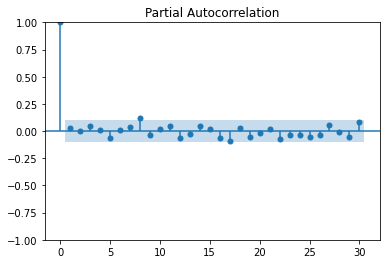

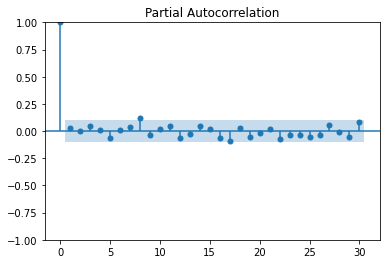

In [11]:
# Plot PACF
plot_pacf(clipped_sales_log, lags=30)

**PACF Plot:** <br>
The partial autocorrelation function (PACF) plot helps in identifyng the correlation of the time series with its past values.
<br>

**Observation:** <br>
From the PACF plot above, it observed that lag 1 is very strong, which defines that yesterday have stong influence on today. Also, after lag 1, the spikes remain very close to the confidence band and hardly breach it. It can also be concluded that, there is no strong sign of any seasonality in the data.

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Define future
horizon = 14

# Train/Test Split
train_size = len(clipped_sales_log) - horizon
train, test = clipped_sales_log.iloc[:train_size], clipped_sales_log.iloc[train_size:]

# Hypertune p
mae_scores = []
rmse_scores = []
models = {}

for p in range(1, 31):
    model = AutoReg(train, lags=p).fit()
    pred = model.predict(start=train_size, end=train_size+horizon-1)
    
    mae_val = mean_absolute_error(test, pred)
    mae_scores.append(mae_val)
    rmse_val = np.sqrt(mean_squared_error(test, pred))
    rmse_scores.append(rmse_val)
    models[p] = (model, pred)
    
    print(f"AR({p}) -> MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}")

AR(1) -> MAE: 1.13, RMSE: 1.39
AR(2) -> MAE: 1.12, RMSE: 1.39
AR(3) -> MAE: 1.12, RMSE: 1.39
AR(4) -> MAE: 1.12, RMSE: 1.39
AR(5) -> MAE: 1.14, RMSE: 1.40
AR(6) -> MAE: 1.14, RMSE: 1.40
AR(7) -> MAE: 1.13, RMSE: 1.39
AR(8) -> MAE: 1.11, RMSE: 1.38
AR(9) -> MAE: 1.12, RMSE: 1.38
AR(10) -> MAE: 1.11, RMSE: 1.38
AR(11) -> MAE: 1.09, RMSE: 1.37
AR(12) -> MAE: 1.10, RMSE: 1.37
AR(13) -> MAE: 1.10, RMSE: 1.36
AR(14) -> MAE: 1.09, RMSE: 1.36
AR(15) -> MAE: 1.08, RMSE: 1.37
AR(16) -> MAE: 1.10, RMSE: 1.36
AR(17) -> MAE: 1.15, RMSE: 1.38
AR(18) -> MAE: 1.14, RMSE: 1.37
AR(19) -> MAE: 1.15, RMSE: 1.38
AR(20) -> MAE: 1.16, RMSE: 1.38
AR(21) -> MAE: 1.15, RMSE: 1.38
AR(22) -> MAE: 1.13, RMSE: 1.36
AR(23) -> MAE: 1.16, RMSE: 1.37
AR(24) -> MAE: 1.16, RMSE: 1.37
AR(25) -> MAE: 1.14, RMSE: 1.35
AR(26) -> MAE: 1.14, RMSE: 1.34
AR(27) -> MAE: 1.12, RMSE: 1.34
AR(28) -> MAE: 1.13, RMSE: 1.34
AR(29) -> MAE: 1.15, RMSE: 1.36
AR(30) -> MAE: 1.13, RMSE: 1.33


In [13]:
# Select best p and best model 
best_p = np.argmin(mae_scores) + 1
best_model_ar, best_pred = models[p]

# Output
print(f"Best p: {best_p}")
print(f"Best 14-day MAE: {mae_scores[best_p-1]:.2f}")
print(f"Best 14-day RMSE: {rmse_scores[best_p-1]:.2f}")

Best p: 15
Best 14-day MAE: 1.08
Best 14-day RMSE: 1.37


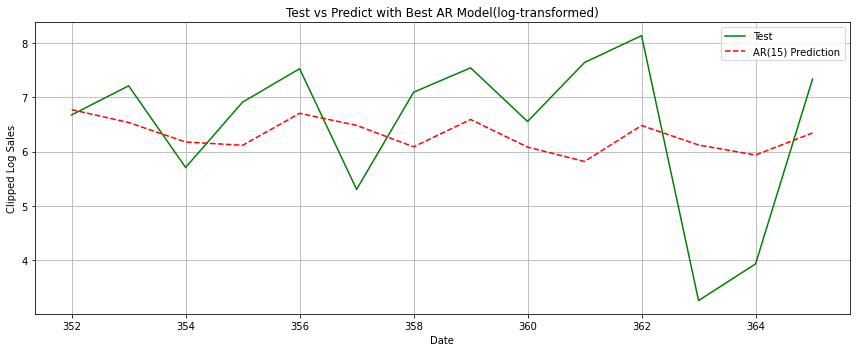

In [14]:
# Plot the test data and predicted values (log-transformed)
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label="Test", color='green')
plt.plot(test.index, best_pred, label=f"AR({best_p}) Prediction", color='red', linestyle='--')
plt.title("Test vs Predict with Best AR Model(log-transformed)")
plt.xlabel("Date")
plt.ylabel("Clipped Log Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


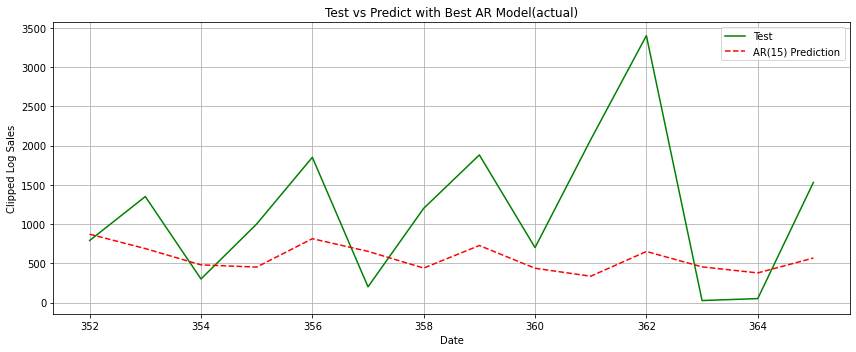

In [15]:
# Calculate actual values by inverting the log transform
y_pred_actual = np.expm1(best_pred)
y_true_actual = np.expm1(test)

# Plot the test data and predicted values (actual)
plt.figure(figsize=(12, 5))
plt.plot(test.index, np.expm1(test), label="Test", color='green')
plt.plot(test.index, np.expm1(best_pred), label=f"AR({best_p}) Prediction", color='red', linestyle='--')
plt.title("Test vs Predict with Best AR Model(actual)")
plt.xlabel("Date")
plt.ylabel("Clipped Log Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Model - 2 : Non-linear Auto Regressive (NAR) model: MLP Regressor

In [16]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
# Define function to create dataset with defined lags
def create_lagged_dataset(series, lag, horizon):
    X, y = [], []
    for i in range(len(series)-lag-horizon+1):
        X.append(series[i:i+lag])
        y.append(series[i+lag:i+lag+horizon])
    return np.array(X), np.array(y)

# Define series, LAG, and 
series = clipped_sales_log.values
lag, horizon = 30, 14

# Create lagged dataset
X, y = create_lagged_dataset(series, lag, horizon)

# Train/test split
X_train, X_test = X[:-1], X[-1:]
y_train, y_test = y[:-1], y[-1]

# Define model and parameter grid
base_model = MLPRegressor(max_iter=3000, random_state=42)
param_grid = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'estimator__activation': ['relu', 'tanh'],
    'estimator__alpha': [0.0001, 0.001, 0.01],
    'estimator__learning_rate': ['constant', 'adaptive']
}

# Wrap in MultiOutputRegressor for multi-step forecasting
multi_output_model = MultiOutputRegressor(base_model)
grid_search = GridSearchCV(multi_output_model, param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=3, n_jobs=-1, verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model_nar = grid_search.best_estimator_
y_pred = best_model_nar.predict(X_test).flatten()

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [18]:
# Calculate the MAE and RMSE on log transformed values
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Output
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best 14-day MAE: {mae:.2f}")
print(f"Best 14-day RMSE: {rmse:.2f}")

Best Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (50,), 'estimator__learning_rate': 'constant'}
Best 14-day MAE: 0.98
Best 14-day RMSE: 1.31


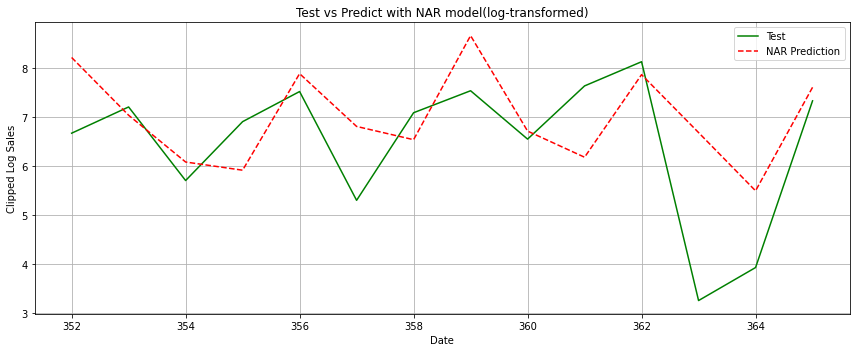

In [19]:
# Plot the test data and predicted values (log-transformed)
plt.figure(figsize=(12, 5))
plt.plot(test.index, y_test, label="Test", color='green')
plt.plot(test.index, y_pred, label=f"NAR Prediction", color='red', linestyle='--')
plt.title("Test vs Predict with NAR model(log-transformed)")
plt.xlabel("Date")
plt.ylabel("Clipped Log Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

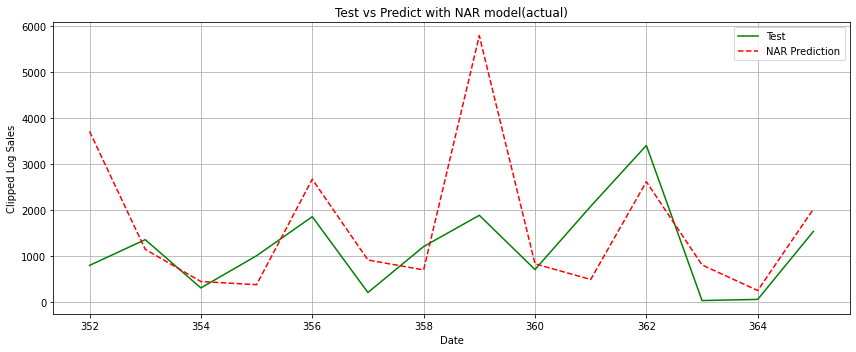

In [20]:
# Calculate actual values by inverting the log transform
y_pred_actual = np.expm1(y_pred)
y_true_actual = np.expm1(y_test.flatten())

# Plot the test data and predicted values (actual)
plt.figure(figsize=(12, 5))
plt.plot(test.index, y_true_actual, label="Test", color='green')
plt.plot(test.index, y_pred_actual, label=f"NAR Prediction", color='red', linestyle='--')
plt.title("Test vs Predict with NAR model(actual)")
plt.xlabel("Date")
plt.ylabel("Clipped Log Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Save best model
import joblib
joblib.dump(best_model_nar, "best_model_nar.pkl")

['best_model_nar.pkl']

In [22]:
# Load the saved model
model_path = "best_model_nar.pkl"
model_nar = joblib.load(model_path)

# Forecast next 14 days from end of series
last_input = clipped_sales_log.values[-lag:].reshape(1, -1)
forecast_nar_log = model_nar.predict(last_input).flatten()
forecast_nar = np.expm1(forecast_nar_log)

# Forecast 14 future steps
forecast_dates = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=horizon)
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecasted_Sales": forecast_nar
})

# Print forecast
print(forecast_df)

         Date  Forecasted_Sales
0  2024-01-02       1335.940057
1  2024-01-03       1202.720253
2  2024-01-04       1847.563439
3  2024-01-05        547.831254
4  2024-01-06       5919.323906
5  2024-01-07        112.045570
6  2024-01-08       1138.479626
7  2024-01-09         82.162768
8  2024-01-10        341.176777
9  2024-01-11        231.117536
10 2024-01-12       1056.050342
11 2024-01-13        194.494492
12 2024-01-14       1636.652473
13 2024-01-15        530.901092


### Model - 3 : Multivariate model: Gradient Boost Regressor(GBR) Model

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Feature DataFrame
df_feat = aggregated_df.copy()
df_feat['Weekday'] = df_feat['Date'].dt.weekday
df_feat['IsWeekend'] = df_feat['Weekday'].isin([5, 6]).astype(int)
df_feat['Month'] = df_feat['Date'].dt.month
df_feat['DayMonth'] = df_feat['Date'].dt.day

lag = 30

# Add lag features
for lag in range(1, lag+1):
    df_feat[f'Lag_{lag}'] = df_feat['ClippedSalesLog'].shift(lag)

df_feat.dropna(inplace=True)

# Prepare features and target
X = df_feat.drop(columns=['Date', 'DailySales', 'ClippedSales', 'ClippedSalesLog'])
y = df_feat['ClippedSalesLog']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=14, shuffle=False)

In [24]:
# Model and hyperparameter grid
model_gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=model_gbr,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train, y_train)

# Evaluate
best_model_gbr = grid_search.best_estimator_
y_pred = best_model_gbr.predict(X_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [25]:
# Calculate the MAE and RMSE on log transformed values
mae_gbr = mean_absolute_error(y_test, y_pred)
rmse_gbr = mean_squared_error(y_test, y_pred, squared=False)

# Output
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best 14-day MAE: {mae_gbr:.2f}")
print(f"Best 14-day RMSE: {rmse_gbr:.2f}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best 14-day MAE: 1.28
Best 14-day RMSE: 1.55


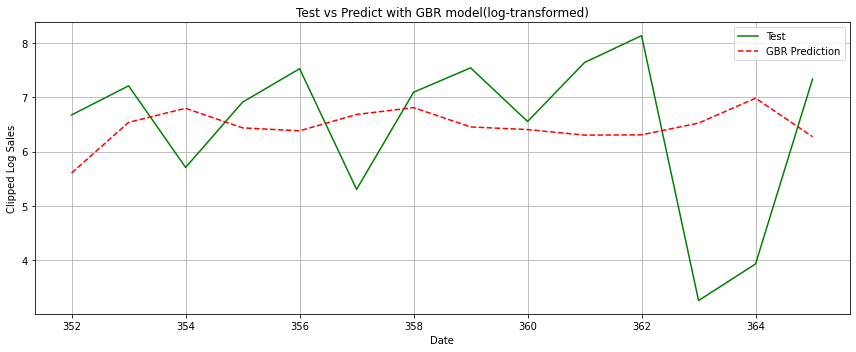

In [26]:
# Plot the test data and predicted values (log-transformed)
plt.figure(figsize=(12, 5))
plt.plot(test.index, y_test, label="Test", color='green')
plt.plot(test.index, y_pred, label=f"GBR Prediction", color='red', linestyle='--')
plt.title("Test vs Predict with GBR model(log-transformed)")
plt.xlabel("Date")
plt.ylabel("Clipped Log Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

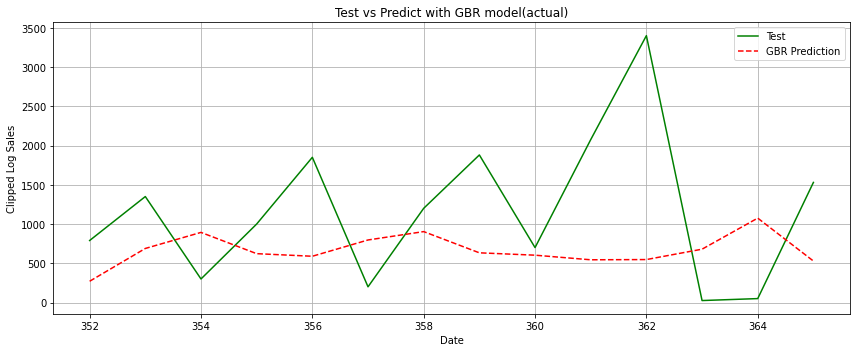

In [27]:
# Calculate actual values by inverting the log transform
y_pred_actual = np.expm1(y_pred)
y_true_actual = np.expm1(y_test)

# Plot the test data and predicted values (actual)
plt.figure(figsize=(12, 5))
plt.plot(test.index, y_true_actual, label="Test", color='green')
plt.plot(test.index, y_pred_actual, label=f"GBR Prediction", color='red', linestyle='--')
plt.title("Test vs Predict with GBR model(actual)")
plt.xlabel("Date")
plt.ylabel("Clipped Log Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Performance Summary

Three models were traind, namely: <br>
1. Auto Regressive(p) model
2. Non-linear Auto Regressive(NAR) model
3. Gradient Boost Regressor(GBR) Model
<br>

Out of which AR and NAR are univariate models, while the GBR is a multivariate model.<br>
The performance of the models are shown below.

In [28]:
# Define results
results = [
    {"Model": "AR(15)", "MAE": 1.08, "RMSE": 1.37},
    {"Model": "NAR (MLP)", "MAE": 0.98, "RMSE": 1.31},
    {"Model": "Gradient Boosting", "MAE": 1.28, "RMSE": 1.55}
]

# Create DataFrame and display
comparison_df = pd.DataFrame(results)
comparison_df

,Model,MAE,RMSE
0,AR(15),1.08,1.37
1,NAR (MLP),0.98,1.31
2,Gradient Boosting,1.28,1.55


## Conclusion

All these models are used to forecast the sales over a horizon of 14-days. From the performance table, it is clearly observed that Non-linear Auto Regressive(NAR) model, is outperfomring others with **lowest MAE (0.98) and RMSE (1.31)**. The AR(p) model also performed competitively well. Gradient boosting underformed most likely due to feature limitations or underfitting.
<br>

**Overall, NAR model is the most suitable for deployment in this scenario.**